In [1]:
%reload_ext autoreload
%autoreload 2

The following example was taken from Reddy (2005) "An introduction to non-linear finite element analysis" Section 9.4.5.

Here we present numerical results obtained for a cantilevered rectangular plate of length a = 10 in, height b = 1 in, and thickness h = 0:1 in, and subjected to uniformly distributed in-plane load ty = -q0, acting downward, along its length. The material of the plate has a modulus of elasticity E = 1.2E7 psi and Poisson's ratio of nu = 0.3.

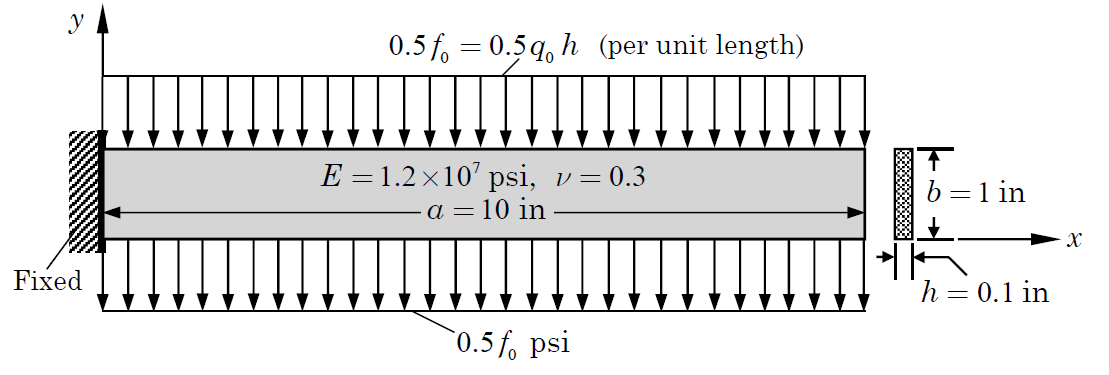

### General Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Mesh definition

In [3]:
from mesh_utils import UniformQuadMesh2D

lx = 10                             # Dimension along x-coord
ly = 1                              # Dimension along y-coord
nx = 4                              # Number of elements along x-coord
ny = 1                              # Number of elements along y-coord
element_type = ['Q4','Q8','Q9']     # Type of elements

cantilever_mesh = {}
for etype in element_type:
    cantilever_mesh[etype] = UniformQuadMesh2D(lx, ly, nx, ny, elem_type=etype)
    cantilever_mesh[etype].compute()

We print some mesh information for Q4

In [4]:
print(f'\nNodal coordinates:\n {cantilever_mesh["Q4"].coordinates}')
print(f'\nElement connectivity:\n {cantilever_mesh["Q4"].elements}')

print(f'\nNumber of nodes: {cantilever_mesh["Q4"].nnod}')
print(f'Number of elements: {cantilever_mesh["Q4"].nelem}')


Nodal coordinates:
 [[ 0.   0. ]
 [ 2.5  0. ]
 [ 5.   0. ]
 [ 7.5  0. ]
 [10.   0. ]
 [ 0.   1. ]
 [ 2.5  1. ]
 [ 5.   1. ]
 [ 7.5  1. ]
 [10.   1. ]]

Element connectivity:
 {'quad': [array([7, 6, 1, 2]), array([8, 7, 2, 3]), array([9, 8, 3, 4]), array([10,  9,  4,  5])]}

Number of nodes: 10
Number of elements: 4


In [5]:
cantilever_mesh['Q4'].node_groups

{'all': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'bottom': [1, 2, 3, 4, 5],
 'top': [6, 7, 8, 9, 10],
 'left': [1, 6],
 'right': [5, 10]}

In [6]:
cantilever_mesh['Q4'].element_groups

{'all': [1, 2, 3, 4],
 'bottom': [1, 2, 3, 4],
 'top': [1, 2, 3, 4],
 'left': [1],
 'right': [4]}

### Dirichlet boundary conditions

In [7]:
from feinn_solver import BoundaryCondition

cantilever_bc = {
                'left': [BoundaryCondition(dof=1, value=0.0),
                        BoundaryCondition(dof=2, value=0.0)]
                }

### Define material

In [8]:
from matmodels import LinearElasticPlaneStress

dummy_mat = LinearElasticPlaneStress(emod = 1.2*1e7, nu = 0.20)

cantilever_matfld = {'all': dummy_mat}

### von Neumman boundary conditions

In [9]:
from feinn_solver import EdgeLoad

cantilever_edge_loads = {
                        'top': EdgeLoad(side = 1, ftangential = 0.0, fnormal = -600, reference = "global"),
                        'bottom': EdgeLoad(side = 3, ftangential = 0.0, fnormal = -600, reference = "global"),
                        }

### Model

#### FEM: infinitesimal formulation

In [10]:
cantilever_thickness = {
                        'all': 0.1
                        }

In [11]:
from feinn_solver import NFEA

# for infinitesimal formulation
cantilever_fem = NFEA(mesh = cantilever_mesh['Q4'], 
                      bcs = cantilever_bc, 
                      matfld = cantilever_matfld,
                      thickness = cantilever_thickness,
                      edge_loads = cantilever_edge_loads,
                      verbose = True
                      )

[matfld] Assigned: ['all']
[matfld] All 4 elements have assigned material
[thickness] Applied 1 thickness groups
[edge_load] Applied 2 edge load groups
[BC] Processed 2 Dirichlet condition(s) → 4 total constraint(s)
[BC] Applied Dirichlet BCs → 4 fixed DOFs


In [12]:
cantilever_fem.Fext_total

tensor([   0., -300.,    0., -600.,    0., -600.,    0., -600.,    0., -300.,
           0., -300.,    0., -600.,    0., -600.,    0., -600.,    0., -300.])

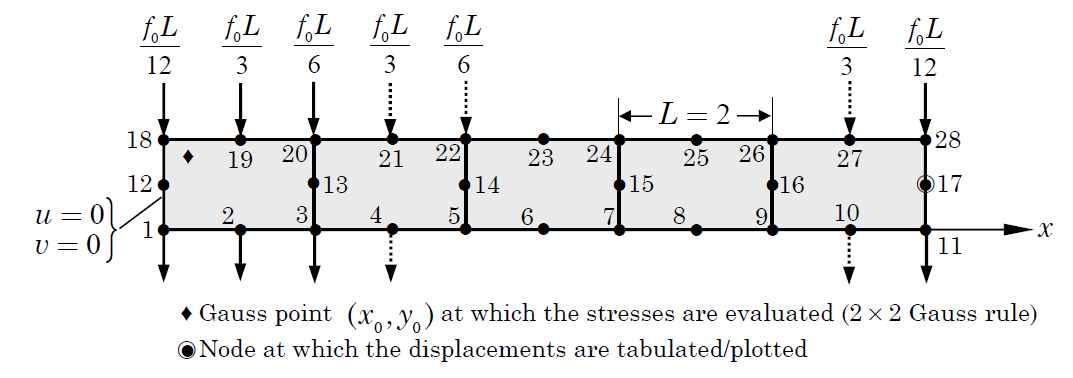

In [13]:
cantilever_fem.run_complete(nsteps=1)

[Load] Set load factor = 1.0000.
Iter   1 | du error: 1.00e+00  Res error: 7.29e-13  Energetic error: 1.00e+00
Iter   2 | du error: 5.38e-13  Res error: 4.45e-13  Energetic error: -2.32e-18
Converged in 2 iterations


In [14]:
cantilever_fem.udisp

tensor([ 0.0000,  0.0000, -0.0643, -0.1817, -0.0977, -0.6017, -0.1106, -1.1314,
        -0.1131, -1.6937,  0.0000,  0.0000,  0.0643, -0.1817,  0.0977, -0.6017,
         0.1106, -1.1314,  0.1131, -1.6937])

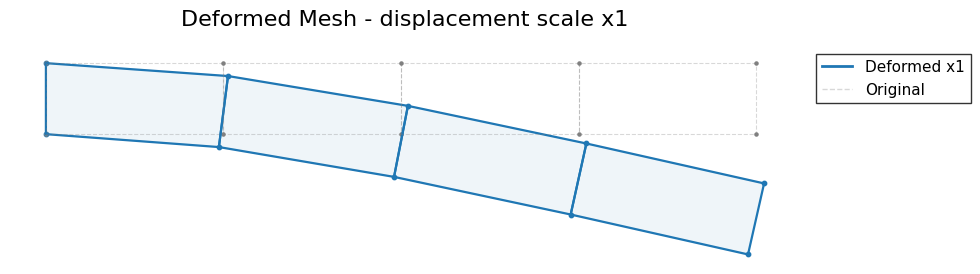

In [15]:
cantilever_fem.plot_deformed_mesh(scale=1)

#### FEINN: infinitesimal formulation

In [16]:
from feinn_solver import FEINN
from nn_models import mFCNet, FCResNet
import torch.nn as nn

feinn_solver = FEINN(
    mesh=cantilever_mesh['Q4'],
    bcs=cantilever_bc,
    matfld=cantilever_matfld,
    thickness = cantilever_thickness,
    edge_loads=cantilever_edge_loads,
    verbose=False,
    nnet = mFCNet(),
    bc_weight=1e6,
    nnet_init = 'xavier',
    )

In [17]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

cfg.epochs = 2000
cfg.learning_rate = 1e-2
cfg.lr_min = 1e-5

In [18]:
import torch

optimizer = torch.optim.Adam(
    feinn_solver.nnet.parameters(),
    lr = cfg.learning_rate,
    weight_decay = 0,
  )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max = cfg.epochs,
    eta_min = cfg.lr_min
  )

# Entrenar
feinn_solver.train(epochs = cfg.epochs, 
                   optimizer = optimizer, 
                   scheduler = scheduler,
                   lbfgs_epochs = 20,
                   warmup = True, 
                   verbose = True)

[FEINN] Starting warmup for zero initial displacement
[FEINN] Warmup completado - salida inicial ≈ 0
[FEINN] Zero-output init: max |u| inicial = 1.63e-03

Epoch 1/2000
Total Loss: 1.532e+01
  Domain: 1.528e+01
  BC:     3.742e-02

Epoch 500/2000
Total Loss: 3.818e+01
  Domain: 3.619e+01
  BC:     1.982e+00

Epoch 1000/2000
Total Loss: 8.439e+00
  Domain: 8.404e+00
  BC:     3.489e-02

Epoch 1500/2000
Total Loss: 6.537e+00
  Domain: 6.520e+00
  BC:     1.632e-02

Epoch 2000/2000
Total Loss: 6.321e+00
  Domain: 6.307e+00
  BC:     1.444e-02

Epoch 1/20 (L-BFGS)
Total Loss: 6.321e+00
  Domain: 4.777e+00
  BC:     8.841e-02

Epoch 20/20 (L-BFGS)
Total Loss: 1.136e-10
  Domain: 1.045e-10
  BC:     9.151e-12


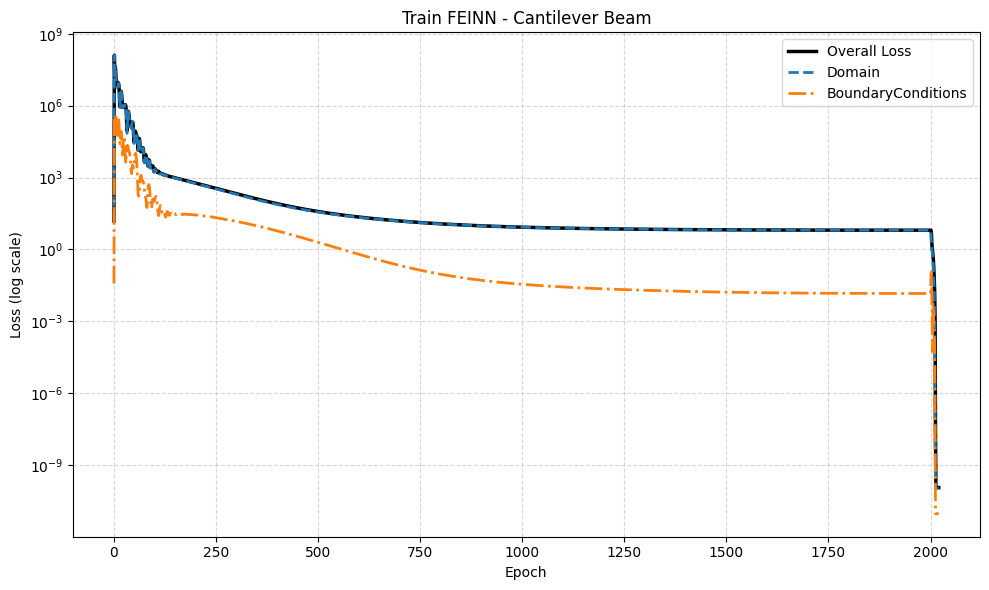

In [19]:
feinn_solver.plot_history(title="Train FEINN - Cantilever Beam")

In [20]:
cantilever_fem.udisp/feinn_solver.udisp

tensor([0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, -0.0000, -0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000])

In [21]:
feinn_solver.udisp

tensor([ 5.3656e-09,  2.4602e-10, -6.4285e-02, -1.8171e-01, -9.7714e-02,
        -6.0171e-01, -1.1057e-01, -1.1314e+00, -1.1314e-01, -1.6937e+00,
        -1.3021e-09, -2.4616e-09,  6.4285e-02, -1.8171e-01,  9.7714e-02,
        -6.0171e-01,  1.1057e-01, -1.1314e+00,  1.1314e-01, -1.6937e+00])

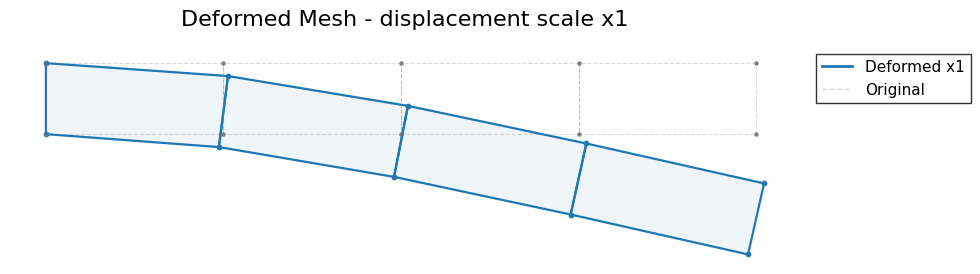

In [22]:
feinn_solver.plot_deformed_mesh(scale=1)

In [23]:
Fint_fem = cantilever_fem._assemble_internal_forces(cantilever_fem.udisp)
Fint_nn = feinn_solver._assemble_internal_forces(feinn_solver.udisp)

Fint_fem / Fint_nn

tensor([ 1.0000e+00,  1.0000e+00, -5.7091e-09,  1.0000e+00,  4.7264e-09,
         1.0000e+00,  1.1461e-08,  1.0000e+00,  3.3924e-09,  1.0000e+00,
         1.0000e+00,  1.0000e+00,  8.0789e-10,  1.0000e+00, -4.3740e-09,
         9.9999e-01,  7.0643e-09,  1.0000e+00, -1.7617e-07,  1.0000e+00])

In [24]:
with torch.no_grad():
    feinn_solver.udisp     = feinn_solver.nnet(feinn_solver.coords_tensor).reshape(-1).detach()
feinn_solver.udisp

tensor([ 5.3656e-09,  2.4602e-10, -6.4285e-02, -1.8171e-01, -9.7714e-02,
        -6.0171e-01, -1.1057e-01, -1.1314e+00, -1.1314e-01, -1.6937e+00,
        -1.3021e-09, -2.4616e-09,  6.4285e-02, -1.8171e-01,  9.7714e-02,
        -6.0171e-01,  1.1057e-01, -1.1314e+00,  1.1314e-01, -1.6937e+00])

In [25]:
cantilever_fem.udisp/feinn_solver.udisp

tensor([0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, -0.0000, -0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000])

#### FEM: TLF formulation

[matfld] Assigned: ['all']
[matfld] All 4 elements have assigned material
[thickness] Applied 1 thickness groups
[edge_load] Applied 2 edge load groups
[BC] Processed 2 Dirichlet condition(s) → 4 total constraint(s)
[BC] Applied Dirichlet BCs → 4 fixed DOFs

[Load] Set load factor = 1.0000.
Iter   1 | du error: 1.00e+00  Res error: 1.20e+02  Energetic error: -1.99e+04
Iter   2 | du error: 8.89e-02  Res error: 3.64e+00  Energetic error: 2.94e+02
Iter   3 | du error: 3.13e-03  Res error: 4.44e-03  Energetic error: 1.28e-02
Iter   4 | du error: 2.17e-04  Res error: 6.54e-06  Energetic error: 6.40e-08
Iter   5 | du error: 5.72e-08  Res error: 3.08e-13  Energetic error: 6.01e-18
Converged in 5 iterations


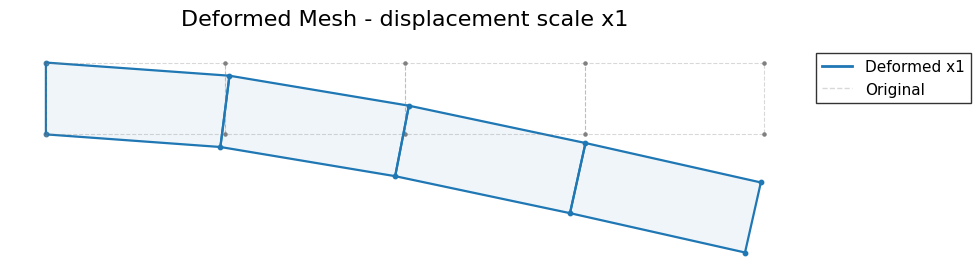

In [26]:
# for TLF formulation
cantilever_nfem = NFEA(mesh = cantilever_mesh['Q4'], 
                      bcs = cantilever_bc, 
                      matfld = cantilever_matfld,
                      thickness = cantilever_thickness,
                      edge_loads = cantilever_edge_loads,
                      formulation = 'TLF',
                      verbose = True
                      )
print('')
cantilever_nfem.run_complete(nsteps=1)

cantilever_nfem.plot_deformed_mesh(scale=1)

In [27]:
cantilever_nfem.udisp

tensor([ 0.0000,  0.0000, -0.0708, -0.1757, -0.1369, -0.5820, -0.2026, -1.0969,
        -0.2657, -1.6448,  0.0000,  0.0000,  0.0557, -0.1830,  0.0543, -0.6005,
         0.0131, -1.1204, -0.0450, -1.6694])

#### FEINN: TLF formulation


[FEINN] Starting warmup for zero initial displacement
[FEINN] Warmup completado - salida inicial ≈ 0
[FEINN] Zero-output init: max |u| inicial = 4.95e-03

Epoch 1/50 (L-BFGS)
Total Loss: 2.301e+02
  Domain: 2.108e+01
  BC:     4.027e+01

Epoch 50/50 (L-BFGS)
Total Loss: 6.168e-10
  Domain: 4.205e-10
  BC:     1.963e-10


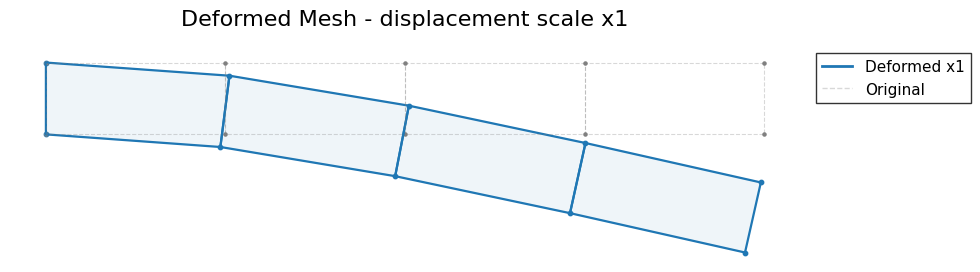

In [28]:
from feinn_solver import FEINN
from nn_models import mFCNet, FCResNet
import torch.nn as nn

# for TLF formulation
feinn_solver_nl = FEINN(
    mesh=cantilever_mesh['Q4'],
    bcs=cantilever_bc,
    matfld=cantilever_matfld,
    thickness = cantilever_thickness,
    edge_loads = cantilever_edge_loads,
    formulation = 'TLF',
    verbose=False,
    nnet = mFCNet(),
    bc_weight=1e6,
    nnet_init = 'xavier',
    )
print('')


# Entrenar
feinn_solver_nl.train(epochs = 0, 
                   lbfgs_epochs = 50,
                   warmup = True, 
                   verbose = True)


feinn_solver_nl.plot_deformed_mesh(scale=1)